# 1. Imports

In [ ]:
%cd "/content"
!mkdir /content/Checkpoint_Files
%cd "/content/drive/My Drive/Colab Notebooks/Gingham/"

# Necessary Imports
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, models, transforms

!pip install split_folders
import split_folders
!pip install import-ipynb
import import_ipynb

import data_cleaner as dclean
import pandas as pd
import MLP_Clean_with_bias as NN
import MLP_Clean_without_bias as NN2
import MLP_Clean as NN3
import gene_selection as gs

import sklearn.feature_selection 
from sklearn.datasets import fetch_openml
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

/content
mkdir: cannot create directory ‘/content/Checkpoint_Files’: File exists
/content/drive/My Drive/Colab Notebooks/Gingham


# 2. Utility Functions

In [ ]:
###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return "/content/Checkpoint_Files/" + path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if use_cuda and torch.cuda.is_available():
          inputs= inputs.cuda()
          labels = labels.cuda()
          net = net.cuda()
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.long())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    

In [ ]:
def plot_training_curve_accuracy(train_acc, val_acc):
    import matplotlib.pyplot as plt
    plt.title("Training Curve - Accuracy")
    n = len(train_acc)
    plt.plot(range(1,n+1), train_acc, label="Training")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def plot_training_curve_loss(train_loss, val_loss):
    import matplotlib.pyplot as plt
    plt.title("Training Curve - Loss")
    n = len(train_acc)
    plt.plot(range(1,n+1), train_loss, label="Training")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

# 3. Data

In [ ]:
train_data = pd.read_csv('khan_train.csv')
train_data.drop(['Unnamed: 0'], axis=1, inplace=True)
train_data = train_data.T

labels = []
for each in list(train_data.index):
    if 'EWS' in each:
        labels.append('EWS')
    elif 'BL' in each:
        labels.append('BL')
    elif 'NB' in each:
        labels.append('NB')
    elif 'RMS' in each:
        labels.append('RMS')

train_data.insert(0, 'labels', labels)

train_data = train_data.reset_index()
train_data

,index,labels,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303,2304,2305,2306,2307
0,EWS.T1,EWS,3.2025,0.0681,1.0460,0.1243,0.4941,3.1207,3.7106,1.8416,1.2607,2.9001,4.0270,1.0643,4.0651,1.4730,2.7932,0.4815,1.4482,3.3214,0.7022,1.7260,1.5136,3.9255,0.5296,3.9098,3.7136,4.0016,1.1819,2.1459,0.6662,1.7203,0.2690,1.4677,0.6380,2.1497,3.7382,2.7538,0.8587,0.9320,...,0.1258,1.6173,0.4661,0.7599,0.2745,0.9985,0.1059,0.5853,3.8000,0.1275,0.5428,0.9514,1.8408,0.2024,0.6766,0.5689,0.5604,0.4027,1.0055,0.4548,0.2620,0.3451,0.7974,0.8585,0.4701,0.2156,0.3792,0.4419,0.2128,0.7948,0.7653,1.6679,0.1493,0.6918,1.4151,0.2756,0.1521,0.3175,0.7240,0.2044
1,EWS.T2,EWS,1.6547,0.0710,1.0409,0.0520,0.2045,2.1609,2.4452,1.1473,0.7371,1.9989,2.6131,0.8541,4.7284,2.4784,1.5103,0.8961,0.4850,2.3431,0.2531,1.7841,1.0886,5.9544,0.5337,2.7007,3.2339,3.4448,2.8296,0.9659,0.4829,1.3528,0.7262,1.2882,2.5171,3.0538,2.8671,1.9144,0.5963,0.9130,...,0.1938,1.0460,0.3609,0.5791,1.1683,1.2184,0.1118,0.6409,1.8589,0.1370,0.6127,0.5862,1.3508,0.5225,0.7216,0.6697,0.4791,0.2255,0.6509,0.2902,0.2171,1.6517,1.4018,1.9379,0.3307,0.1734,2.2825,0.3584,0.4693,1.4629,1.0665,3.6014,0.3048,1.7957,1.0701,0.2688,0.1932,0.4140,1.2708,0.2990
2,EWS.T3,EWS,3.2779,0.1160,0.8926,0.1014,0.2818,1.9773,3.2590,1.4106,0.9548,2.0775,4.8139,0.4257,4.7120,2.7548,1.9162,1.2710,1.1331,2.4818,2.0350,1.7340,2.6863,5.5842,1.1332,4.6055,2.2437,3.8154,1.6393,1.9209,0.7984,1.5175,0.5605,1.5492,1.8893,2.0080,4.8112,2.2913,0.2019,1.2415,...,0.2517,1.5805,0.4393,0.9812,0.1889,0.2487,0.1411,0.4914,2.7463,0.1947,0.3494,0.6460,2.2891,0.4394,0.8380,0.9131,0.8453,0.4718,0.3814,0.3783,0.3050,5.0694,1.1673,2.1713,0.6075,0.2832,0.6821,0.3776,0.6744,1.7190,1.2674,1.5152,0.2382,0.8720,0.6819,0.3221,0.2156,0.3227,1.2142,0.2230
3,EWS.T4,EWS,1.0060,0.1906,0.4302,0.1035,0.2984,1.6804,5.8901,0.2958,0.7381,1.6610,4.9105,1.5866,9.4802,0.1667,1.1314,2.6361,0.8405,0.9928,0.1239,0.5216,0.9867,4.8170,0.6451,2.0627,3.1900,3.4317,0.1925,0.9634,0.3900,0.3349,0.3040,0.3668,1.7941,2.7727,1.3236,0.8575,1.5864,0.4192,...,0.2222,0.0831,0.1247,0.3872,0.0650,0.9711,0.0930,0.6209,3.8167,0.1972,1.1626,0.5633,0.2191,0.4336,1.2013,0.1385,0.3507,0.2304,0.5563,0.1045,0.4819,6.0368,0.7366,1.1104,0.1976,0.3501,0.0790,0.5446,1.2495,0.1422,0.4743,1.0282,0.1049,0.5632,1.2264,0.8123,0.2758,0.3016,0.7235,0.0871
4,EWS.T6,EWS,2.7098,0.2367,0.3693,0.2190,0.3711,1.7800,3.2376,0.6769,0.8546,0.6808,4.5104,0.6461,3.6433,1.7957,1.0375,0.3976,0.8846,1.5156,1.2582,1.0114,1.5428,5.1313,0.6248,4.4183,2.1173,5.5302,1.8151,0.7825,0.4637,0.7564,0.6539,0.9060,0.9905,2.6055,0.9257,1.5953,0.4982,0.8406,...,0.0775,0.7065,0.2509,0.5257,0.8960,0.4636,0.1119,0.2938,1.2584,0.0957,0.2059,1.5336,0.5709,0.1684,0.5880,0.6647,1.0810,0.6542,1.2152,0.5564,0.1663,5.4848,0.3547,2.7707,0.6221,0.4338,0.4045,0.5979,0.2370,0.8404,0.7039,0.5961,0.0707,0.4001,1.5271,0.4084,0.6412,0.3552,1.3928,0.2157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,RMS.T5,RMS,1.8594,0.5240,0.6808,0.3013,0.4011,3.5232,7.2830,0.9024,1.9208,0.8450,3.9057,0.6986,5.7215,1.7486,1.1167,0.3983,0.4677,1.8998,0.3859,0.5380,0.9687,6.7251,0.3642,4.6571,2.6641,5.0751,0.7179,0.3831,0.3580,0.6479,0.6580,0.3964,0.9645,2.4129,2.5048,2.3362,0.5664,0.5590,...,0.1132,0.3681,0.4357,1.1594,0.6704,1.1592,0.3050,0.6763,0.9292,0.2928,0.2969,0.4967,0.4087,0.2557,0.4325,0.3960,0.5366,0.4822,1.8837,1.0001,0.3737,0.6954,0.4124,2.8241,0.6094,0.2920,0.3258,0.4054,0.4285,0.4618,0.8641,0.2971,0.4911,0.3096,0.4337,0.3058

In [ ]:
def select(data, number_of_genes, score_func = chi2, split = False, test_percentage=0.1, seed=43):
    cancer = {'EWS': 0, 'BL': 1, 'NB': 2, 'RMS': 3}

    characteristics = np.array([cancer[item] for item in data['labels']], dtype=float)
    
    characteristics_no_ohe = characteristics

    if score_func == chi2:
        characteristics = characteristics.reshape(-1, 1)
        ohe = OneHotEncoder()
        characteristics = ohe.fit_transform(characteristics).toarray()
    
    genes = [gene for gene in data.columns][2:]
    
    expression = np.array(data[genes], dtype=float)
    expression = np.array([gene for gene in expression if any([i in str(gene) for i in '0123456789'])], dtype=float)

    test = SelectKBest(score_func= score_func, k=number_of_genes)
    fit = test.fit(expression,characteristics)
    features = fit.transform(expression)

    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(genes)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Gene','Score']
    print(featureScores.nlargest(number_of_genes,'Score'))      #print x best features
    
    top_genes = list(featureScores.nlargest(number_of_genes,'Score')['Gene'])
    
    features = np.array(data[top_genes], dtype=float)
    features = np.array([gene for gene in features if any([i in str(gene) for i in '0123456789'])], dtype=float)
    
    if score_func != chi2:
        characteristics = characteristics.reshape(-1, 1)
        ohe = OneHotEncoder()
        characteristics = ohe.fit_transform(characteristics).toarray()

    if split == True:
        #splitty
        x_train_i, x_test_i, y_train_i, y_test_i = train_test_split(features, characteristics_no_ohe, test_size=test_percentage, random_state=seed)
    
        #transpose these to be (nx,m) nx = features, m = samples
        x_train_i, x_test_i, y_train_i, y_test_i = x_train_i.T, x_test_i.T, y_train_i.T, y_test_i.T

        #splitty
        x_train_ohe, x_test_ohe, y_train_ohe, y_test_ohe = train_test_split(features, characteristics, test_size=test_percentage, random_state=seed)
    
        #transpose these to be (nx,m) nx = features, m = samples
        x_train_ohe, x_test_ohe, y_train_ohe, y_test_ohe = x_train_ohe.T, x_test_ohe.T, y_train_ohe.T, y_test_ohe.T
    
        return x_train_i, y_train_i, x_test_i, y_test_i, x_train_ohe, y_train_ohe, x_test_ohe, y_test_ohe
    
    else:
        return features.T, characteristics.T, characteristics_no_ohe.T


# 4. Model

In [ ]:
torch.manual_seed(1) # set the random seed

# 96% on MNIST - 16 epochs

class ANN(nn.Module):
    def __init__(self, num_genes, num_hidden, multi_layered=False):
        super(ANN, self).__init__()
        self.name = 'ANN'
        self.multi_layered = multi_layered
        self.layer1 = nn.Linear(num_genes, num_hidden)
        self.layer2 = nn.Linear(num_hidden, 4)
        self.multi_layers = nn.Sequential(
            nn.Linear(num_genes, 128),
            nn.Linear(128, 64),
            nn.Linear(64, num_hidden)
        )
        self.dropout1 = nn.Dropout(p=0.05)

    def forward(self, x):
        if self.multi_layered:
            x = self.multi_layers(x)
        else: 
            x = self.layer1(x)
        #x = self.dropout1(x)
        x = F.relu(x)
        x = self.layer2(x)
        m = nn.Softmax(dim=-1)
        x = m(x)
        #x = F.relu(x)
        #x = self.layer3(x)
        return x

In [ ]:
ANN1 = ANN(18, 9)
ANN1.cuda()
summary(ANN1, (16, 18)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 16, 9]             171
            Linear-2                [-1, 16, 4]              40
Total params: 211
Trainable params: 211
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# 5. Training

### Training Functions

In [ ]:
def train_net(encoder, net, train_loader, val_loader, batch_size, learning_rate=0.005, num_epochs=6):
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.

    if encoder == 'ohe': 
        criterion = nn.MSELoss()
    else:
        criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    optimizer_val = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc, val_acc = [], []
    train_loss, val_loss = [], []
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()

    n = 0
    for epoch in range(num_epochs-1):  # loop over the dataset multiple times
        loss = 0.0
        i=0
        for imgs, labels in iter(train_loader):
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()
            # Zero the parameter gradients
            optimizer.zero_grad()
            #print(imgs.shape)
            # Forward pass, backward pass, and optimize
            #print(imgs.shape)
            #print(imgs)
            outputs = net(imgs.float())
            #print(outputs.shape)
            #print(outputs)
            #print(labels.shape)
            #print(labels)
            if encoder == 'ohe':
                loss = criterion(outputs, labels.float())
            else:
                loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            n += 1 
        
        loss_val = 0.0
        for imgs_val, labels_val in val_loader:
            if use_cuda and torch.cuda.is_available():
              imgs_val = imgs_val.cuda()
              labels_val = labels_val.cuda()
              net = net.cuda()
            #optimizer_val.zero_grad()
            outputs_val = net(imgs_val.float())
            if encoder == 'ohe':
                loss_val = criterion(outputs_val, labels_val.float())
            else:
                loss_val = criterion(outputs_val, labels_val.long())
            #optimizer_val.step()
        
        train_loss.append(loss.item())
        val_loss.append(loss_val.item())
        
        train_acc.append(get_accuracy(model, train_loader, encoder))
        val_acc.append(get_accuracy(model, val_loader, encoder))

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

        if epoch % 10 == 0:
            print("Epoch: " + str(epoch) + " Training Accuracy: " + str(train_acc[-1]) + " Validation Accuracy: " +  str(val_acc[-1]))
            print(str(n) + "th Iteration.")
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    print("Highest Validation Accuracy: " + str(max(val_acc)) + ' at ' + str(val_acc.index(max(val_acc))) + ' epochs.')
    print("Checkpointed model file path: " + get_model_name(net.name, batch_size, learning_rate, val_acc.index(max(val_acc))))
    return train_acc, val_acc, train_loss, val_loss
    # Write the train/test loss/err into CSV file for plotting later
    #epochs = np.arange(1, num_epochs + 1)
    #np.savetxt("{}_train_err.csv".format(model_path), train_err)
    #np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    #np.savetxt("{}_val_err.csv".format(model_path), val_err)
    #np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
def get_accuracy(model, data_loader, encoder):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
          model = model.cuda()

        output = model(imgs.float())
        
        pred = output.max(1, keepdim=True)[1]

        if encoder == 'ohe':
            correct += pred.eq(labels.max(1, keepdim=True)[1].view_as(pred)).sum().item()
        else:
            correct += pred.eq(labels.view_as(pred)).sum().item()
        
        total += imgs.shape[0]
    return correct / total

### Dataloader

In [ ]:
gene_number = 18
num_hidden = 9

X_train_i, Y_train_i, X_test_i, Y_test_i, X_train_ohe, Y_train_ohe, X_test_ohe, Y_test_ohe = select(train_data, gene_number, split=True)

      Gene       Score
508    508  259.514641
186    186  190.312871
245    245  101.519729
1954  1954   95.015672
1388  1388   87.035237
1833  1833   81.244161
1953  1953   74.601886
1318  1318   74.016484
544    544   73.546669
2045  2045   73.268533
1914  1914   70.534519
1644  1644   70.064383
1707  1707   69.299313
553    553   68.635956
741    741   61.513693
1915  1915   60.766495
565    565   57.066600
671    671   54.092289


Ordinal Encoding

In [ ]:
X_train_i = np.log2(X_train_i)
X_test_i = np.log2(X_test_i)

X_train_i = X_train_i.T
X_test_i = X_test_i.T

train_data_i = []
for i in range(len(X_train_i)):
    train_data_i.append([X_train_i[i], Y_train_i[i]])

test_data_i = []
for i in range(len(X_test_i)):
    test_data_i.append([X_test_i[i], Y_test_i[i]])

train_loader_i = torch.utils.data.DataLoader(train_data_i, shuffle=True, batch_size=8)
test_loader_i = torch.utils.data.DataLoader(test_data_i, shuffle=True, batch_size=8)

One-Hot Encoding

In [ ]:
X_train_ohe = np.log2(X_train_ohe)
X_test_ohe = np.log2(X_test_ohe)

X_train_ohe = X_train_ohe.T
X_test_ohe = X_test_ohe.T

Y_train_ohe = Y_train_ohe.T
Y_test_ohe = Y_test_ohe.T

train_data_ohe = []
for i in range(len(X_train_ohe)):
    train_data_ohe.append([X_train_ohe[i], Y_train_ohe[i]])

test_data_ohe = []
for i in range(len(X_test_ohe)):
    test_data_ohe.append([X_test_ohe[i], Y_test_ohe[i]])

train_loader_ohe = torch.utils.data.DataLoader(train_data_ohe, shuffle=True, batch_size=8)
test_loader_ohe = torch.utils.data.DataLoader(test_data_ohe, shuffle=True, batch_size=8)

### Tuning

In [ ]:
!cp -r /content/Checkpoint_Files/model_ANN_bs16_lr0.001_epoch18 /content

In [ ]:
# 18 genes, 9 hidden nodes -> OHE
torch.manual_seed(1) # set the random seed
model = ANN(gene_number, num_hidden, multi_layered=False)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=8, num_epochs=300, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.3508771929824561 Validation Accuracy: 0.5714285714285714
8th Iteration.
Epoch: 10 Training Accuracy: 0.45614035087719296 Validation Accuracy: 0.7142857142857143
88th Iteration.
Epoch: 20 Training Accuracy: 0.6491228070175439 Validation Accuracy: 1.0
168th Iteration.
Epoch: 30 Training Accuracy: 0.8947368421052632 Validation Accuracy: 1.0
248th Iteration.
Epoch: 40 Training Accuracy: 0.8947368421052632 Validation Accuracy: 1.0
328th Iteration.
Epoch: 50 Training Accuracy: 0.9473684210526315 Validation Accuracy: 1.0
408th Iteration.
Epoch: 60 Training Accuracy: 0.9649122807017544 Validation Accuracy: 1.0
488th Iteration.
Epoch: 70 Training Accuracy: 0.9649122807017544 Validation Accuracy: 1.0
568th Iteration.
Epoch: 80 Training Accuracy: 0.9824561403508771 Validation Accuracy: 1.0
648th Iteration.
Epoch: 90 Training Accuracy: 0.9824561403508771 Validation Accuracy: 1.0
728th Iteration.
Epoch: 100 Training Accuracy: 0.9

### Sanity Check

In [ ]:
# 18 genes, 9 hidden nodes -> OHE
torch.manual_seed(1) # set the random seed
model = ANN(gene_number, num_hidden, multi_layered=False)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train_acc, val_acc, train_loss, val_loss = train_net('ohe', model, train_loader_ohe, test_loader_ohe, batch_size=16, num_epochs=3000, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch: 0 Training Accuracy: 0.3333333333333333 Validation Accuracy: 0.5714285714285714
4th Iteration.
Epoch: 100 Training Accuracy: 0.9649122807017544 Validation Accuracy: 1.0
404th Iteration.
Epoch: 200 Training Accuracy: 0.9824561403508771 Validation Accuracy: 1.0
804th Iteration.
Epoch: 300 Training Accuracy: 1.0 Validation Accuracy: 1.0
1204th Iteration.
Epoch: 400 Training Accuracy: 1.0 Validation Accuracy: 1.0
1604th Iteration.
Epoch: 500 Training Accuracy: 1.0 Validation Accuracy: 1.0
2004th Iteration.
Epoch: 600 Training Accuracy: 1.0 Validation Accuracy: 1.0
2404th Iteration.
Epoch: 700 Training Accuracy: 1.0 Validation Accuracy: 1.0
2804th Iteration.
Epoch: 800 Training Accuracy: 1.0 Validation Accuracy: 1.0
3204th Iteration.
Epoch: 900 Training Accuracy: 1.0 Validation Accuracy: 1.0
3604th Iteration.
Epoch: 1000 Training Accuracy: 1.0 Validation Accuracy: 1.0
4004th Iteration.
Epoch: 1100 Training Accuracy: 1.0 Validation Accuracy: 1.0

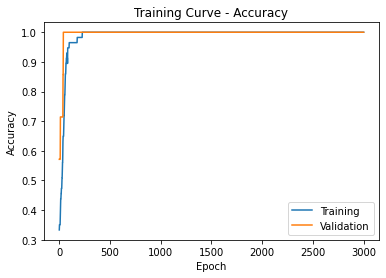

In [ ]:
plot_training_curve_accuracy(train_acc, val_acc)

# Prediction

In [ ]:
test_data = pd.read_csv('khan_test.csv')
test_data.drop(['Unnamed: 0'], axis=1, inplace=True)
test_data = test_data.T

test_data = test_data.reset_index()
test_data

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303,2304,2305,2306,2307
0,TEST.9,1.7733,0.4875,0.5832,0.3514,0.7182,4.7686,8.8864,2.2408,0.8908,3.5985,1.9403,1.3612,2.1857,2.3717,1.5888,0.3136,2.9107,3.7279,0.3505,1.7600,2.5626,9.3218,1.2347,2.4604,1.6341,8.2603,0.5274,0.7296,0.9031,0.8105,0.8949,1.1386,0.4433,4.2474,1.1933,2.6185,7.7096,0.3888,0.8735,...,0.2739,1.5022,0.2443,0.4173,0.9305,1.0553,0.1851,0.3251,0.7409,0.5408,0.9944,0.5929,0.2840,0.1598,0.6233,0.7137,2.0048,0.3587,0.4657,0.8036,0.2478,0.1564,0.6027,1.5289,0.6686,0.2493,0.2769,0.4386,0.1708,0.6835,1.7174,0.7078,0.1307,0.2834,0.1558,0.2899,0.2239,0.3658,0.6412,0.2182
1,TEST.11,0.1397,0.0846,2.3266,0.1188,0.3497,2.6046,3.9808,1.8516,1.3238,1.9454,3.2956,1.0344,4.0892,2.0508,0.9285,0.4244,0.8724,3.3105,0.2917,3.0101,2.1741,5.4105,0.2681,5.0679,2.1997,3.9288,2.0200,1.2535,0.4735,3.3393,1.0854,2.0820,0.0831,1.7432,2.3485,2.1763,0.4978,0.1223,0.8840,...,0.1056,1.7221,1.1242,1.9790,2.2478,0.9946,0.3218,0.9322,0.8959,0.0630,0.2836,0.3033,0.6373,0.4204,1.2800,0.4068,0.4320,0.3170,0.4241,1.2592,0.7022,0.4161,0.5291,1.0345,0.5749,0.1515,0.8248,0.3211,0.1041,0.6671,0.7283,1.3666,0.2613,1.1244,0.2988,0.2298,0.1414,0.1283,0.7414,0.7103
2,TEST.5,1.9420,0.2103,2.4897,0.1770,0.5963,2.9903,4.2457,2.4517,1.6298,2.2302,4.1996,1.5528,4.4715,1.4605,1.8162,0.9410,0.8558,2.9127,0.2920,2.7351,1.4814,4.8466,0.5526,1.7417,2.0881,3.9190,0.5844,1.1205,0.3475,1.4527,0.3414,2.4887,0.0490,2.1495,3.5360,2.3672,1.2183,0.7373,0.7679,...,0.1036,0.5587,0.3868,0.9762,1.2385,0.5195,0.1489,0.9848,3.6231,0.4063,0.4250,0.6625,0.7191,0.4976,0.8511,0.1817,1.1623,0.4371,0.8073,0.6482,1.0391,1.5931,1.1410,1.0428,0.8293,0.4956,1.9372,0.2877,0.0793,0.1554,0.2924,0.4544,0.5507,0.2250,0.2284,0.6212,0.1504,1.9152,0.9166,0.1850
3,TEST.8,0.7721,0.1855,1.1922,0.0979,0.1841,0.9914,9.9955,1.5774,0.7100,2.0473,7.8634,0.7915,8.9656,1.3517,0.4465,0.6234,1.5958,0.5582,0.1685,0.6951,0.7064,5.0801,0.4739,1.4495,0.8860,6.7279,0.5141,0.8316,0.0800,2.0190,0.5358,1.0643,0.3840,1.8097,2.2453,2.3255,0.7986,0.9876,0.5493,...,0.0907,0.7351,0.2608,1.2785,1.1109,0.4898,0.3506,0.6347,3.1704,0.2091,0.2990,0.3359,0.3704,0.3222,1.3217,0.2211,0.5830,0.3972,0.4610,0.3375,0.9168,0.0862,0.5252,7.0105,0.6628,0.2725,0.6683,0.3046,0.2751,0.4046,0.1288,0.2941,0.3197,0.3858,1.3418,0.2996,0.2328,0.5194,0.9413,0.3751
4,TEST.10,0.3296,0.3510,0.4258,0.0737,0.1702,0.2839,4.1636,0.4754,1.8462,0.5868,14.1507,0.4207,3.0975,0.9741,0.3225,0.9427,0.7053,0.4827,0.1177,0.7070,0.5077,3.2983,0.2293,0.7930,0.3376,4.4077,0.4054,0.7607,0.3533,2.0133,0.1899,0.5549,1.2440,1.5121,3.7501,1.3962,0.2808,0.5508,0.3125,...,0.9881,0.0898,0.1650,1.2180,0.1394,0.6720,0.0922,0.2823,5.1466,0.1057,0.7202,0.5694,0.6458,0.8868,1.9489,0.1865,0.8763,0.6709,0.7908,0.5115,0.2605,0.7856,1.0575,0.7074,0.7999,0.1271,0.4027,0.3825,3.9252,0.5216,0.3817,0.3617,0.3710,0.5255,0.0979,0.2380,0.6157,1.6150,0.3655,0.4591
5,TEST.13,0.7509,0.4165,1.2165,0.1280,0.2474,0.3816,6.8751,1.2534,0.7674,6.2661,4.9384,2.9907,4.3241,1.6786,0.9100,0.2205,2.0263,0.5197,0.0992,1.0220,2.0020,2.1652,0.6627,0.6123,0.1093,12.3566,0.3511,0.6092,0.4144,0.6004,0.3690,0.9189,0.2964,1.5820,1.1459,1.3436,8.8657,0.7812,0.8155,...,0.4405,0.0748,0.5707,0.7228,0.4020,0.5958,0.1456,0.7168,2.6950,0.7834,1.2503,0.6670,0.5058,0.2750,1.5527,1.3328,1.4856,0.3872,0.7080,0.9718,0.2974,0.1207,0.7509,13.9052,0.8540,0.2814,0.3503,0.3595,0.3396,0.2862,0.6200,0.2454,0.2307,0.2375,0.1286,0.3392,0.2993,0.3876,0.8141,0.2449
6,TEST.3,1.4407,0.3036,2.9190,1.1618,0.1502,0.2694,5.3357,0.3843,1.8788,0.3960,6.6662,0.1890,3.2433,0.9366,1.2587,2.1336,1.9706,2.1234,1.6768,0.2675,0.5506,6.8246,0.6736,5.9164,0.8557,3.1997,0.2092,0.5447,0.1336,1.5309,0.1359,1.4147,0.0626,0.9716,3.9333,5.3675,0.5823,0.0465,0.610

In [ ]:
def predict(net, model_path, sample):
    state = torch.load(model_path)
    net.load_state_dict(state)
    x = torch.from_numpy(sample)
    output = net(x.float())
    return output

In [ ]:
net = ANN(gene_number, num_hidden)
#model_path = get_model_name(net.name, batch_size=16, learning_rate=0.001, epoch=18)
model_path = get_model_name(net.name, batch_size=8, learning_rate=0.001, epoch=39)
predict(net, model_path, X_test_i[3])

tensor([0.7633, 0.0778, 0.0800, 0.0789], grad_fn=<SoftmaxBackward>)

In [ ]:
Y_test_i[3]

0.0

# Weight Export

In [ ]:
w = list(net.parameters())

In [ ]:
w

[Parameter containing:
 tensor([[ 0.1877, -0.0583, -0.0470,  0.1485, -0.2213,  0.1909, -0.0626,  0.0901,
           0.0428,  0.0100,  0.0604, -0.0117,  0.0672, -0.0709, -0.0505, -0.0521,
           0.0076,  0.0446],
         [ 0.1429,  0.0163, -0.0778, -0.1865, -0.0330, -0.1205, -0.0566,  0.0441,
           0.1408,  0.0882, -0.2274,  0.1754,  0.0839,  0.1941,  0.1812, -0.2037,
          -0.1990, -0.1291],
         [ 0.1837, -0.0859,  0.1343, -0.1292,  0.2608, -0.1107,  0.2046,  0.0153,
          -0.0866,  0.0759, -0.1433,  0.0881, -0.0593, -0.0594, -0.2418, -0.1597,
           0.1340, -0.0621],
         [ 0.1106,  0.0503,  0.0721, -0.2332,  0.2186,  0.0329, -0.0652,  0.2505,
           0.2036,  0.1166, -0.1242,  0.0488,  0.0717, -0.0376, -0.1910, -0.1861,
           0.1938, -0.0591],
         [ 0.1272,  0.0103,  0.0952,  0.0450,  0.1066,  0.1384, -0.2007,  0.1293,
          -0.1416, -0.1862,  0.0203, -0.0272,  0.1547, -0.1439, -0.2302,  0.1575,
          -0.0286,  0.1548],
         [ 0